# Predictive Parameters in Logistic Regression: Making Sense of it All 

In [1]:
import pandas as pd
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)

## Import Data and Summary Statistics

In [2]:
fraud = pd.read_csv("data/card_transdata.csv")
fraud.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


## Create Model Pipeline

In [3]:
features = list(fraud.iloc[:,0:7].columns)

cont_feat = features[:3]
bin_feat = features[3:]

normalize = ColumnTransformer([
    ('cont', StandardScaler(), cont_feat),
    ('binary','passthrough',bin_feat)
    ])

pipeline = Pipeline([
    ('normalize',normalize),
    ('logit',LogisticRegression())
    ])

# Fit Pipeline
model = pipeline.fit(fraud[features],fraud['fraud'])

# Final Model
final_mod = model._final_estimator

## Compute Logit Marginal Effects

In [4]:
from functions.marg_eff import logit_margeff

In [5]:
logit_margeff(final_mod, fraud[features], features, kind='probability')

,features,marginal_effects_probability
0,distance_from_home,0.024
1,distance_from_last_transaction,0.016
2,ratio_to_median_purchase_price,0.058
3,repeat_retailer,-0.015
4,used_chip,-0.025
5,used_pin_number,-0.323
6,online_order,0.160


In [6]:
logit_margeff(final_mod, fraud[features], features, kind='odds')

,features,marginal_effects_odds
0,distance_from_home,2.699
1,distance_from_last_transaction,1.918
2,ratio_to_median_purchase_price,11.110
3,repeat_retailer,0.538
4,used_chip,0.351
5,used_pin_number,0.000
6,online_order,757.573


## Visualizations

In [10]:
x = np.arange(-0.25,1.25,0.001)

z =1/(1+np.exp(-((x-0.5)/0.1)))
y=x

dz = (1/0.1)*(np.exp(-((x-0.5)/0.1))/(1+np.exp(-((x-0.5)/0.1)))**2)


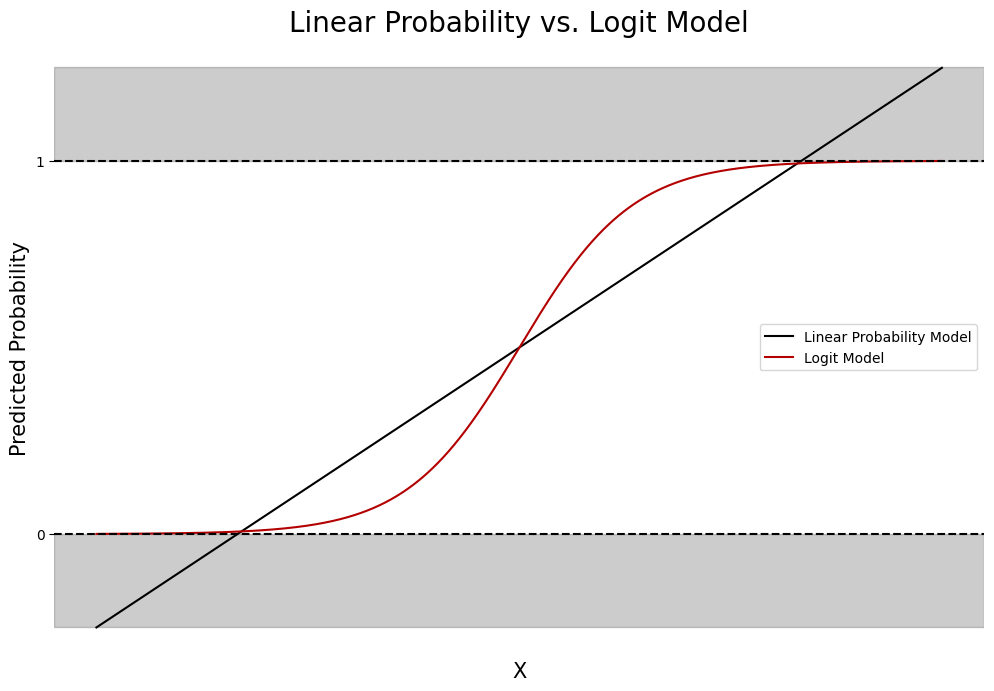

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x,y,color='black',label='Linear Probability Model',zorder=1)
ax.plot(x,z,color='#b30000',label='Logit Model',zorder=2)
ax.legend()
ax.axhline(y=0,color='black',linestyle='--')
ax.axhline(y=1,color='black',linestyle='--')
#ax.grid(True)
ax.set_ylabel('Predicted Probability',size=15)
ax.set_xlabel('X',size=15)
ax.set_yticks([0,1])
ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False,top=False)
ax.set_title("Linear Probability vs. Logit Model",size=20)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['left'].set_visible(False)
ax.axhspan(0, -0.25,alpha=0.2,color='black')
ax.axhspan(1, 1.25,alpha=0.2,color='black')
plt.show()

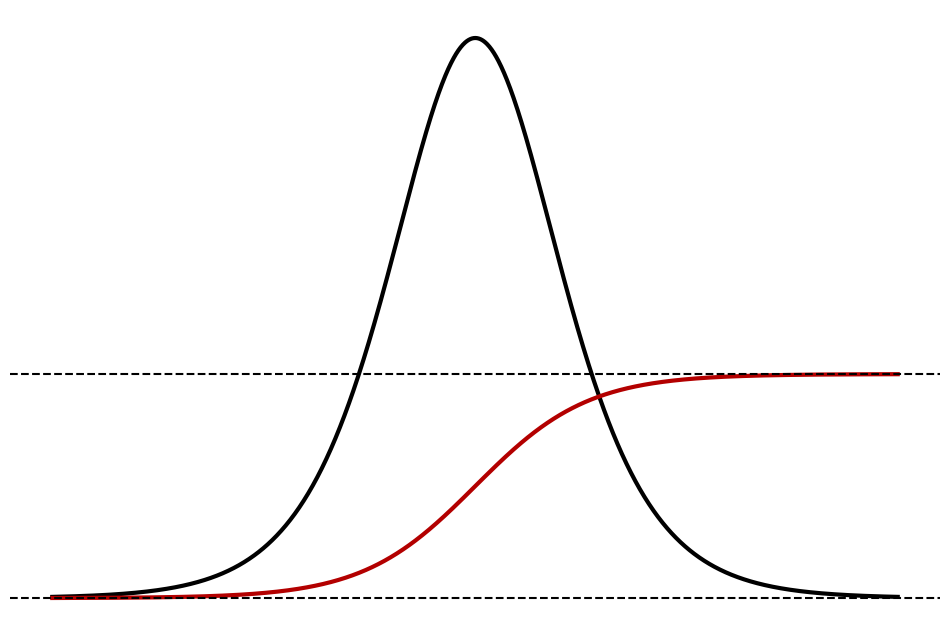

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x,dz,color='black',label='Logistic PDF',zorder=1,linewidth=3)
ax.plot(x,z,color='#b30000',label='Logitistc CDF',zorder=2,linewidth=3)
#ax.legend()
ax.axhline(y=0,color='black',linestyle='--')
ax.axhline(y=1,color='black',linestyle='--')
#ax.grid(True)
ax.set_ylabel('',size=15)
ax.set_xlabel('',size=15)
ax.set_yticks([])
ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False,top=False)
#ax.set_title("Logistic Distribution",size=20,)
fig.gca().spines['top'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['bottom'].set_visible(False)
fig.gca().spines['left'].set_visible(False)
plt.show()

## Appendix A: Computing with Statsmodels 
### (Will be slightly different due to estimation differences)

In [13]:
# Z-Score
for x in ['distance_from_home','distance_from_last_transaction',
                          'ratio_to_median_purchase_price']:
    
    fraud[x]=(fraud[x] - fraud[x].mean())/fraud[x].std()

In [14]:
logit = sm.logit('''fraud~distance_from_home+distance_from_last_transaction+
                   ratio_to_median_purchase_price+repeat_retailer+used_chip+
                   used_pin_number+online_order'''
                   , data=fraud).fit()

logit.summary()

Optimization terminated successfully.
         Current function value: 0.135695
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  fraud   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999992
Method:                           MLE   Df Model:                            7
Date:                Fri, 30 Sep 2022   Pseudo R-squ.:                  0.5423
Time:                        15:12:33   Log-Likelihood:            -1.3570e+05
converged:                       True   LL-Null:                   -2.9649e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -8.2557      0.040   -208.278      0.000      -8.333      -8.178
distance_from_home                 0.9951      0.005    182.831      0.000       0.984       1.006
distance_from_last_transaction     0.6527      0.006    105.614      0.000       0.641       0.665
ratio_to_median_purchase_price     2.4139      0.008    303.723      0.000       2.398       2.430
repeat_retailer                   -0.6215      0.016    -39.456      0.000      -0.652      -0.591
used_chip                         -1.0491      0.012    -85.804      0.000      -1.073      -1.025
used_pin_number                  -13.7404      0.159    -86.663      0.000     -14.051     -13.430
online_order                       6.6514      0.037    178.712      0.000       6.578       6.724
==================================================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [15]:
logit.get_margeff(at='overall').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  fraud
Method:                          dydx
At:                           overall
==================================================================================================
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
distance_from_home                 0.0379      0.000    192.809      0.000       0.038       0.038
distance_from_last_transaction     0.0249      0.000    107.416      0.000       0.024       0.025
ratio_to_median_purchase_price     0.0920      0.000    360.622      0.000       0.091       0.092
repeat_retailer                   -0.0237      0.001    -39.511      0.000      -0.025      -0.023
used_chip                         -0.0400      0.000    -86.028      0.000      -0.041      -0.039
used_pin_number                   -0.5236      0.006    -87.653      0.000      -0.535      -0.512
online_order                       0.2535      0.001    186.082      0.000       0.251       0.256
==================================================================================================
"""

## Appendix B: SHAP Interpolation (A little Hackish - Under Review)

In [16]:
import shap

c:\Users\jakep\Coding\miniconda3\envs\Blog-Posts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Features and Target
X = fraud.drop('fraud',axis=1).copy().to_numpy()
y = fraud['fraud'].copy()

# Fit model
log_reg = LogisticRegression().fit(X,y)

In [18]:
# Fit Model Agnostic Explainer

X_summary = shap.kmeans(X,100)
explainer = shap.KernelExplainer(log_reg.predict_proba, X_summary)

In [19]:
# Get SHAP values for random subset of data

index = np.random.choice(X.shape[0], 10000, replace=False)
X_shap = pd.DataFrame(X[index],columns=features)

shap_values = explainer.shap_values(X_shap)
shap_df = pd.DataFrame(shap_values[1],columns=features)

shap_sum = shap_df.sum(axis=1) # Sum of Shap Values for each individual
pred_probas = pd.Series(log_reg.predict_proba(X[index])[:,1]) # predicted probability for each individual

100%|██████████| 10000/10000 [07:54<00:00, 21.07it/s]


In [20]:
from scipy.interpolate import interp1d

shap_sort = shap_sum.sort_values()
pred_probas_sort = pred_probas[shap_sort.index]

interpolate = interp1d(shap_sort, pred_probas_sort, bounds_error=False,fill_value=(0,1))

margins = shap_df.apply(lambda x: shap_sum - x).apply(interpolate).apply(lambda x: pred_probas - x)

### Marginal Effect Visualizations

In [21]:
import seaborn as sns

bands_df = X_shap.assign(ratio_to_median_purchase_price_bands = pd.qcut(X_shap["ratio_to_median_purchase_price"], 20),
                         distance_from_home_bands = pd.qcut(X_shap['distance_from_home'],20),
                         distance_from_last_transaction_bands = pd.qcut(X_shap['distance_from_last_transaction'],20))

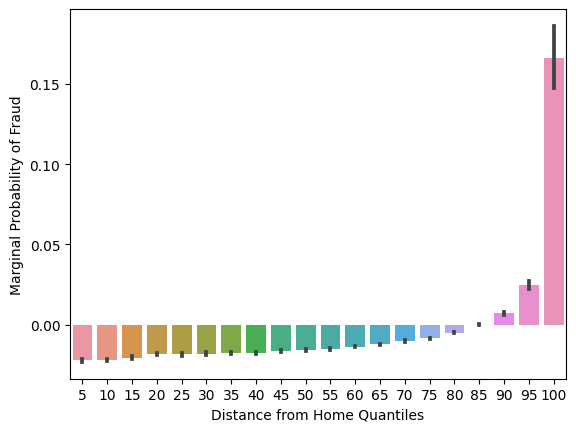

In [30]:
# Distance from Home

fig,ax = plt.subplots()
sns.barplot(y=margins['distance_from_home'],x=bands_df['distance_from_home_bands'])
ax.set_xticklabels(labels=[x for x in range(5,105,5)])
ax.set_ylabel('Marginal Probability of Fraud')
ax.set_xlabel('Distance from Home Quantiles')
plt.show()

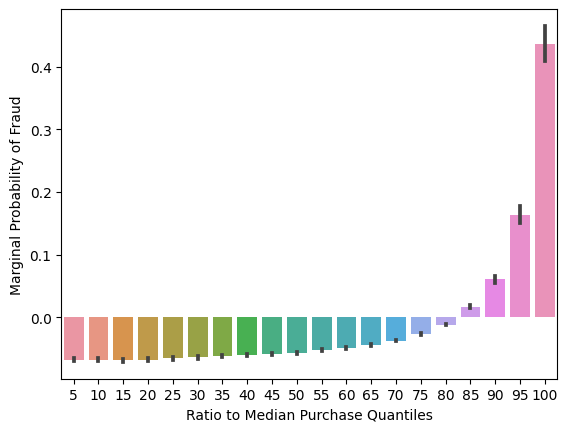

In [31]:
# Ratio to median purchase price

fig,ax = plt.subplots()
sns.barplot(y=margins['ratio_to_median_purchase_price'],x=bands_df['ratio_to_median_purchase_price_bands'])
ax.set_xticklabels(labels=[x for x in range(5,105,5)])
ax.set_ylabel('Marginal Probability of Fraud')
ax.set_xlabel('Ratio to Median Purchase Quantiles')
plt.show()

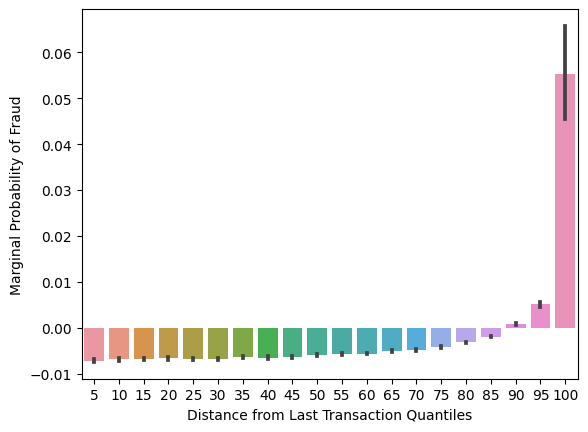

In [32]:
# Distance from last transaction

fig,ax = plt.subplots()
sns.barplot(y=margins['distance_from_last_transaction'],x=bands_df['distance_from_last_transaction_bands'])
ax.set_xticklabels(labels=[x for x in range(5,105,5)])
ax.set_ylabel('Marginal Probability of Fraud')
ax.set_xlabel('Distance from Last Transaction Quantiles')
plt.show()

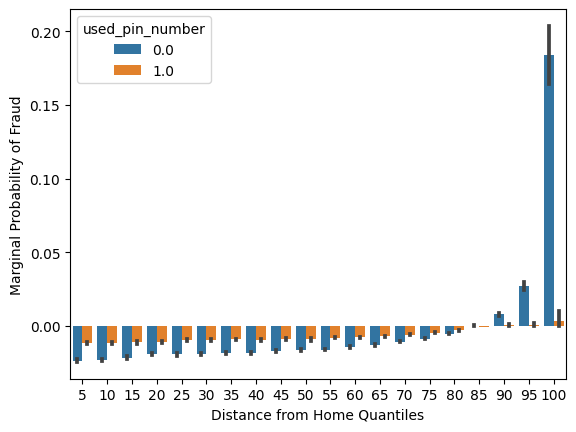

In [33]:
# Interaction (Distance from Home and Using Pin Number)

fig,ax = plt.subplots()
sns.barplot(y=margins['distance_from_home'],x=bands_df['distance_from_home_bands'],hue=bands_df['used_pin_number'])
ax.set_xticklabels(labels=[x for x in range(5,105,5)])
ax.set_ylabel('Marginal Probability of Fraud')
ax.set_xlabel('Distance from Home Quantiles')
plt.show()